In [1]:
import pandas as pd
import numpy as np
import pickle
import scipy.optimize as optim
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


Today we are going to explore the methods of unfairness problem in Machine Learning. Since Propublica organization pointed out that the COMPAS(Correctional Offender Management Profiling for Alternative Sanction) system which is a database containing the criminal history are discrminatory against race and gender.It's analysis shows that Black defandants were often predicted to be at a higher risk of recidivism than they actually were while white defandants were predicted to be less risky. Recidivism is defined as defandants reoffend and get arrested again within two years. And the risk scores evaluated by their systemun results in unfairness between the defandant's recidivism situation. 


In [2]:
#Import the COMPAS dataset.
df = pd.read_csv('../data/compas-scores-two-years.csv')
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,8/14/2013,Male,4/18/1947,69,Greater than 45,Other,...,1,Low,8/14/2013,7/7/2014,7/14/2014,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,1/27/2013,Male,1/22/1982,34,25 - 45,African-American,...,1,Low,1/27/2013,1/26/2013,2/5/2013,0,9,159,1,1
2,4,ed philo,ed,philo,4/14/2013,Male,5/14/1991,24,Less than 25,African-American,...,3,Low,4/14/2013,6/16/2013,6/16/2013,4,0,63,0,1
3,5,marcu brown,marcu,brown,1/13/2013,Male,1/21/1993,23,Less than 25,African-American,...,6,Medium,1/13/2013,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,3/26/2013,Male,1/22/1973,43,25 - 45,Other,...,1,Low,3/26/2013,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,11/23/2013,Male,7/17/1992,23,Less than 25,African-American,...,5,Medium,11/23/2013,11/22/2013,11/24/2013,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2/1/2014,Male,3/25/1993,23,Less than 25,African-American,...,5,Medium,2/1/2014,1/31/2014,2/2/2014,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,1/14/2014,Male,10/1/1958,57,Greater than 45,Other,...,1,Low,1/14/2014,1/13/2014,1/14/2014,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,3/9/2014,Female,11/17/1982,33,25 - 45,African-American,...,2,Low,3/9/2014,3/8/2014,3/9/2014,3,0,754,0,0


Data Preprocessing: From the ProPublica notebook, we removed the rows that 
1. charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested
2. the recidivist flag - is_recid == -1 if we could not find a compas case at all
3. those with a c_charge_degree of 'O' which means ordinary traffic offenses. It will not result in Jail time are removed 
4. since we are only intersted in sample fairness between two races: African-American and Caucasian, we subsets our datasets

In [3]:
#Select useful column and filter out poor quality data
df = df[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'juv_fel_count','juv_misd_count','juv_other_count',
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
ix = df['days_b_screening_arrest'] <= 30
ix = (df['days_b_screening_arrest'] >= -30) & ix
ix = (df['is_recid'] != -1) & ix
ix = (df['c_charge_degree'] != "O") & ix
ix = (df['score_text'] != 'N/A') & ix
df = df.loc[ix,:]
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])).apply(lambda x: x.days)
df = df.loc[df['race'].isin(['African-American','Caucasian'])]
df = df[['race', 'sex', 'age', 'age_cat', 'c_charge_degree', 'score_text', 'priors_count', 'juv_fel_count','juv_misd_count','juv_other_count',
                    'days_b_screening_arrest', 'decile_score', 'length_of_stay', 'two_year_recid']]
df


,race,sex,age,age_cat,c_charge_degree,score_text,priors_count,juv_fel_count,juv_misd_count,juv_other_count,days_b_screening_arrest,decile_score,length_of_stay,two_year_recid
1,African-American,Male,34,25 - 45,F,Low,0,0,0,0,-1.0,3,10,1
2,African-American,Male,24,Less than 25,F,Low,4,0,0,1,-1.0,4,1,1
6,Caucasian,Male,41,25 - 45,F,Medium,14,0,0,0,-1.0,6,6,1
8,Caucasian,Female,39,25 - 45,M,Low,0,0,0,0,-1.0,1,2,0
10,Caucasian,Male,27,25 - 45,F,Low,0,0,0,0,-1.0,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,African-American,Male,30,25 - 45,M,Low,0,0,0,0,-1.0,2,0,1
7208,African-American,Male,20,Less than 25,F,High,0,0,0,0,-1.0,9,0,0
7209,African-American,Male,23,Less than 25,F,Medium,0,0,0,0,-1.0,7,1,0
7210,African-American,Male,23,Less than 25,F,Low,0,0,0,0,-1.0,3,1,0


Here we introduce Learning Fair Representations techiniques to solve unfairness problem, the learning algorithm for fair classification is achieved by formulating fairness as optimization problem of finding good representation. The main idea in this model is to map each individual, represented as a data point in a given input space, to a probability distribution in a new representation space. General speaking, the goal of our model is to learn a good prototype set with the consideration of accuracy and statiscal parity.

Reference: Rich Zemel, Yu Wu, Kevin Swersky, Toni Pitassi, Cynthia Dwork, Learning Fair Representations,
http://proceedings.mlr.press/v28/zemel13.html

Before we built the LFR model, we need to transfer each variable to a learnable indicator value. And according to the research paper, defandants with African-American race are regarded as non-sensitive group , Caucasian defandants are regarded as protected group. 

In [4]:
#Since LFR needs to cageorize sensitive group and non-sensitive group,we regard defandant with African-American as 0,Caucasian as 1
df.loc[df['race'] == 'African-American', 'race']=0
df.loc[df['race'] == 'Caucasian', 'race']=1
df.loc[df['sex'] == 'Male', 'sex']=1
df.loc[df['sex'] == 'Female', 'sex']=0
df.loc[df['age_cat'] == 'Less than 25', 'age_cat']=0
df.loc[df['age_cat'] == '25 - 45', 'age_cat']=1
df.loc[df['age_cat'] == 'Greater than 45', 'age_cat']=2
df.loc[df['score_text'] == 'Low', 'score_text']=0
df.loc[df['score_text'] == 'Medium', 'score_text']=1
df.loc[df['score_text'] == 'High', 'score_text']=2
df.loc[df['c_charge_degree'] == 'F', 'c_charge_degree']=0
df.loc[df['c_charge_degree'] == 'M', 'c_charge_degree']=1
df

,race,sex,age,age_cat,c_charge_degree,score_text,priors_count,juv_fel_count,juv_misd_count,juv_other_count,days_b_screening_arrest,decile_score,length_of_stay,two_year_recid
1,0,1,34,1,0,0,0,0,0,0,-1.0,3,10,1
2,0,1,24,0,0,0,4,0,0,1,-1.0,4,1,1
6,1,1,41,1,0,1,14,0,0,0,-1.0,6,6,1
8,1,0,39,1,1,0,0,0,0,0,-1.0,1,2,0
10,1,1,27,1,0,0,0,0,0,0,-1.0,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,0,1,30,1,1,0,0,0,0,0,-1.0,2,0,1
7208,0,1,20,0,0,2,0,0,0,0,-1.0,9,0,0
7209,0,1,23,0,0,1,0,0,0,0,-1.0,7,1,0
7210,0,1,23,0,0,0,0,0,0,0,-1.0,3,1,0


As defined in the Learning Fair Representation paper, the Loss function **L = A_z * L_z+ A_x * L_x + A_y * L_y**, where **Ax, Ay, Az** are hyper-parameters governing the trade-off between the system's desire data, And relative **Lz, Lx, Ly** are defined as follows


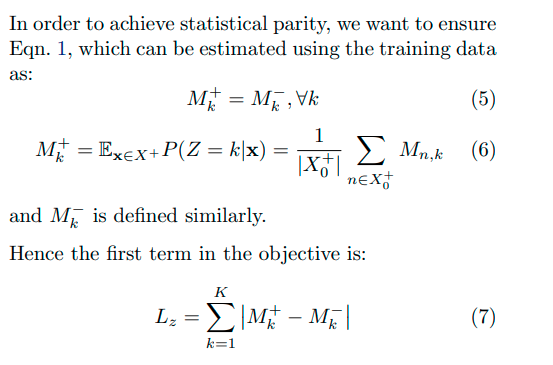

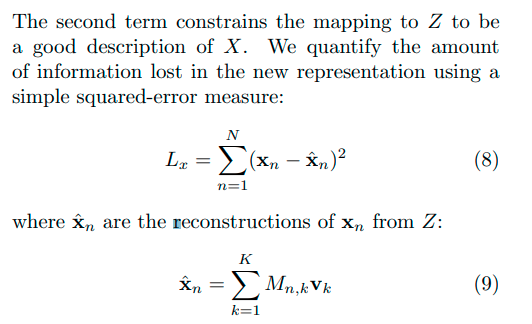

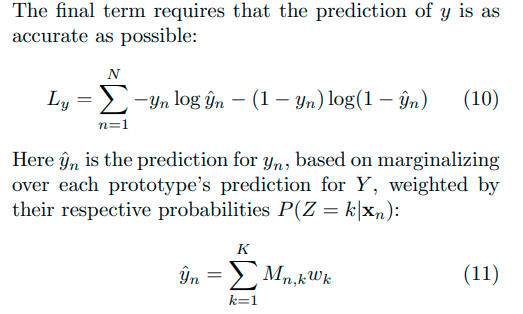

Therefore we defined the following function to calculate the relative value. And here we use scipy.optimizeo package to minimize our Loss function.  

In [5]:
from numba import jit
import numpy as np
    
@jit
def distances(X, v, alpha, N, P, k):
    dists = np.zeros((N, P))
    for i in range(N):
        for p in range(P):
            for j in range(k):    
                dists[i, j] += (X[i, p] - v[j, p]) * (X[i, p] - v[j, p]) * alpha[p]
    return dists

@jit
def M_nk(dists, N, k):
    M_nk = np.zeros((N, k))
    exp = np.zeros((N, k))
    denom = np.zeros(N)
    for i in range(N):
        for j in range(k):
            exp[i, j] = np.exp(-1 * dists[i, j])
            denom[i] += exp[i, j]
        for j in range(k):
            if denom[i]:
                M_nk[i, j] = exp[i, j] / denom[i]
            else:
                M_nk[i, j] = exp[i, j] / 1e-6
    return M_nk

@jit    
def M_k(M_nk, N, k):
    M_k = np.zeros(k)
    for j in range(k):
        for i in range(N):
            M_k[j] += M_nk[i, j]
        M_k[j] /= N
    return M_k

@jit        
def x_n_hat(X, M_nk, v, N, P, k):
    x_n_hat = np.zeros((N, P))
    L_x = 0.0
    for i in range(N):
        for p in range(P):
            for j in range(k):
                x_n_hat[i, p] += M_nk[i, j] * v[j, p]
            L_x += (X[i, p] - x_n_hat[i, p]) * (X[i, p] - x_n_hat[i, p])
    return x_n_hat, L_x

@jit
def yhat(M_nk, y, w, N, k):
    yhat = np.zeros(N)
    L_y = 0.0
    for i in range(N):
        for j in range(k):
            yhat[i] += M_nk[i, j] * w[j]
        yhat[i] = 1e-6 if yhat[i] <= 0 else yhat[i]
        yhat[i] = 0.999 if yhat[i] >= 1 else yhat[i]
        L_y += -1 * y[i] * np.log(yhat[i]) - (1.0 - y[i]) * np.log(1.0 - yhat[i])
    return yhat, L_y

@jit
def LFR(params, data_sensitive, data_nonsensitive, y_sensitive, 
        y_nonsensitive,  k=10, A_x = 1e-4, A_y = 0.1, A_z = 1000, results=0):
    
    LFR.iters += 1 
    Ns, P = data_sensitive.shape
    Nns, _ = data_nonsensitive.shape
    
    alpha0 = params[:P]
    alpha1 = params[P : 2 * P]
    w = params[2 * P : (2 * P) + k]
    v = np.matrix(params[(2 * P) + k:]).reshape((k, P))
        
    dists_sensitive = distances(data_sensitive, v, alpha1, Ns, P, k)
    dists_nonsensitive = distances(data_nonsensitive, v, alpha0, Nns, P, k)

    M_nk_sensitive = M_nk(dists_sensitive, Ns, k)
    M_nk_nonsensitive = M_nk(dists_nonsensitive, Nns, k)
    
    M_k_sensitive = M_k(M_nk_sensitive, Ns, k)
    M_k_nonsensitive = M_k(M_nk_nonsensitive, Nns, k)
    
    L_z = 0.0
    for j in range(k):
        L_z += abs(M_k_sensitive[j] - M_k_nonsensitive[j])

    x_n_hat_sensitive, L_x1 = x_n_hat(data_sensitive, M_nk_sensitive, v, Ns, P, k)
    x_n_hat_nonsensitive, L_x2 = x_n_hat(data_nonsensitive, M_nk_nonsensitive, v, Nns, P, k)
    L_x = L_x1 + L_x2

    yhat_sensitive, L_y1 = yhat(M_nk_sensitive, y_sensitive, w, Ns, k)
    yhat_nonsensitive, L_y2 = yhat(M_nk_nonsensitive, y_nonsensitive, w, Nns, k)
    L_y = L_y1 + L_y2

    criterion = A_x * L_x + A_y * L_y + A_z * L_z

    if LFR.iters % 250 == 0:
        print(LFR.iters, criterion)
      
    if results:
        return yhat_sensitive, yhat_nonsensitive, M_nk_sensitive, M_nk_nonsensitive
    else:
        return criterion
LFR.iters = 0

In [6]:
data = np.array(df)
y = np.array(data[:,-1]).flatten()
data = data[:,:-1]
sensitive = data[:,0]




In [7]:
data = preprocessing.scale(data)
#data = data[:,:-0]
sensitive_idx = np.array(np.where(sensitive==1))[0].flatten()
nonsensitive_idx = np.array(np.where(sensitive!=1))[0].flatten()
data_sensitive = data[sensitive_idx,:]
data_nonsensitive = data[nonsensitive_idx,:]
y_sensitive = y[sensitive_idx]
y_nonsensitive = y[nonsensitive_idx]




In [8]:
training_sensitive,test_sensitive,ytrain_sensitive, ytest_sensitive = train_test_split(data_sensitive, y_sensitive, test_size = 0.15, random_state = 42)
training_nonsensitive,test_nonsensitive,ytrain_nonsensitive, ytest_nonsensitive = train_test_split(data_nonsensitive, y_nonsensitive, test_size = 0.15, random_state = 42)

training = np.concatenate((training_sensitive, training_nonsensitive))
ytrain = np.concatenate((ytrain_sensitive, ytrain_nonsensitive))

test = np.concatenate((test_sensitive, test_nonsensitive))
ytest = np.concatenate((ytest_sensitive, ytest_nonsensitive))
    


We split the protected group and unprotected group first and concatenate them together. Traning sets and testing sets are split proportionally as 6:1, you can see how does each defandants variables are being rescaled and manipulated 

In [9]:
data_sensitive

array([[ 1.22871802,  0.4927064 ,  0.55837559, ...,  0.14213551,
         0.4847697 , -0.18996465],
       [ 1.22871802, -2.02960628,  0.38789451, ...,  0.14213551,
        -1.27517973, -0.27327099],
       [ 1.22871802,  0.4927064 , -0.63499194, ...,  0.14213551,
        -0.21921007, -0.29409758],
       ...,
       [ 1.22871802, -2.02960628, -0.37927033, ...,  0.33688921,
        -1.27517973, -0.29409758],
       [ 1.22871802,  0.4927064 , -0.97595409, ...,  0.14213551,
         1.18874948, -0.27327099],
       [ 1.22871802,  0.4927064 , -1.14643516, ...,  0.14213551,
         0.4847697 , -0.25244441]])

In [10]:
#Set the prototype sets k=5
k=5
rez = np.random.uniform(size=data.shape[1] * 2 + k + data.shape[1] * k)
yhat_sensitive, yhat_nonsensitive, M_nk_sensitive, M_nk_nonsensitive = LFR(rez,
                                                                           training_sensitive,
                                                                           training_nonsensitive,
                                                                           ytrain_sensitive,
                                                                           ytrain_nonsensitive,
                                                                           k, 1e-4, 0.1, 1000,
                                                                           results=1)
#print(yhat_sensitive.shape)
#print(yhat_nonsensitive.shape)
#print(M_nk_sensitive.shape)
#print(M_nk_nonsensitive.shape)

test_yhat_sensitive, test_yhat_nonsensitive, test_M_nk_sensitive, test_M_nk_nonsensitive = LFR(rez,
                                                                           test_sensitive,
                                                                           test_nonsensitive,
                                                                           ytest_sensitive,
                                                                           ytest_nonsensitive,
                                                                           k, 1e-4, 0.1, 1000,
                                                                           results = 1)


<ipython-input-5-451ec7726e1b>:61: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "LFR" failed type inference due to: non-precise type array(pyobject, 1d, C)
During: typing of argument at <ipython-input-5-451ec7726e1b> (65)

File "<ipython-input-5-451ec7726e1b>", line 65:
def LFR(params, data_sensitive, data_nonsensitive, y_sensitive, 
    <source elided>
    
    LFR.iters += 1 
    ^

  @jit
C:\ProgramData\Anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "LFR" was compiled in object mode without forceobj=True.

File "<ipython-input-5-451ec7726e1b>", line 62:
@jit
def LFR(params, data_sensitive, data_nonsensitive, y_sensitive, 
^

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\ProgramData\Anaconda3\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprec

In [11]:
bnd = []
for i, k2 in enumerate(rez):
    if i < data.shape[1] * 2 or i >= data.shape[1] * 2 + k:
        bnd.append((None, None))
    else:
        bnd.append((0, 1))

rez = optim.fmin_l_bfgs_b(LFR, x0=rez, epsilon=1e-5,
                          args=(training_sensitive, training_nonsensitive,
                                ytrain_sensitive, ytrain_nonsensitive, k, 1e-4,
                                0.1, 1000, 0),
                          bounds = bnd, approx_grad=True, maxfun=150000,
                          maxiter=150000, iprint=-1)


250 824.9696573997247
500 402.6446019661465
750 367.3145356722914
1000 453.52060920583074
1250 334.9486309045996
1500 321.9583544676858
1750 338.27068329142554
2000 316.05192702666045
2250 311.6588596538373
2500 309.0295207667172
2750 307.6823417820991
3000 307.810747459316
3250 307.24441525793503
3500 307.23012543214685
3750 307.21308471747807
4000 307.0241483355981
4250 307.47446286708407
4500 307.0260159738963
4750 307.0385219909748
5000 307.01074396294393
5250 307.01003032054746
5500 307.0094955267876
5750 307.00851715083803
6000 307.0088598000351
6250 307.0299972905433
6500 307.0106296782988
6750 307.0084074234144
7000 307.00878307184956
7250 307.0274810193991
7500 307.00816067587726
7750 307.0122071836459
8000 307.009702111267
8250 307.00789966369786
8500 307.0109314081526
8750 307.00835164979173


In [12]:
w = rez[0][data.shape[1]*2:data.shape[1]*2+k]

v = rez[0][data.shape[1]*2+k:].reshape(k,data.shape[1])


ytest_sensitive_pred = test_M_nk_sensitive.dot(np.expand_dims(w,axis=1))
ytest_nonsensitive_pred = test_M_nk_nonsensitive.dot(np.expand_dims(w,axis=1))

ytest_sensitive = ytest_sensitive.flatten()
ytest_sensitive = list(ytest_sensitive)

ytest_nonsensitive = ytest_nonsensitive.flatten()
ytest_nonsensitive = list(ytest_nonsensitive)

target = ytest_sensitive + ytest_nonsensitive

ytest_sensitive_pred = ytest_sensitive_pred.flatten()
ytest_sensitive_pred = list(ytest_sensitive_pred)

ytest_nonsensitive_pred = ytest_nonsensitive_pred.flatten()
ytest_nonsensitive_pred = list(ytest_nonsensitive_pred)

pred = ytest_sensitive_pred + ytest_nonsensitive_pred

len(target),len(pred)



(793, 793)

In [13]:
pred

[0.4991996259601139,
 0.5330297091095406,
 0.6262292502668232,
 0.49688343909060617,
 0.4650770246387721,
 0.40494253775281913,
 0.5240411086745,
 0.47277604333602397,
 0.44539014914685215,
 0.5039786967679797,
 0.4566856526530434,
 0.5432102913181533,
 0.518656584841217,
 0.48154930491066245,
 0.4863308393651243,
 0.3636629182186095,
 0.35148666071998436,
 0.3841059617338569,
 0.37833964927816144,
 0.4768480916800212,
 0.41766054352371884,
 0.4860182662007757,
 0.457427146779391,
 0.5003609635259219,
 0.6538094867845914,
 0.4712995626917554,
 0.47377693160154555,
 0.53138831008983,
 0.502826311209938,
 0.3129779357363177,
 0.47490367845050874,
 0.47589201492614086,
 0.6893228645484376,
 0.5016885666281103,
 0.5213947162712863,
 0.5289743948426799,
 0.468389191764527,
 0.3749646040847317,
 0.5436314732233273,
 0.538914208241972,
 0.47520161340158057,
 0.5356359173452978,
 0.48381832993458446,
 0.46094603662814093,
 0.5285472760062682,
 0.500090992169834,
 0.47277604333602397,
 0.523610